In [35]:
!pip install git+https://github.com/speechbrain/speechbrain.git

  Cloning https://github.com/speechbrain/speechbrain.git to /tmp/pip-req-build-0ieeq4gn
  Running command git clone --filter=blob:none --quiet https://github.com/speechbrain/speechbrain.git /tmp/pip-req-build-0ieeq4gn
  Resolved https://github.com/speechbrain/speechbrain.git to commit 5beaece0b4cdcce18f303cbb1f5f04b0a879dca2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [36]:
!pip install pydub
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Multimodal Project/audio"
test = "/content/drive/MyDrive/Multimodal Project/test_data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import numpy as np
import librosa
from sklearn.cluster import KMeans
import soundfile as sf
from pydub import AudioSegment

# Function to extract features from the speech signal
def extract_features(signal, sr=22050, frame_length=2048, hop_length=512, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length)
    return mfccs.T

# Function to perform vector quantization
def vector_quantization(features, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(features)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    return centroids, labels

# Function to reconstruct audio from quantized features
def reconstruct_audio(centroids, labels, hop_length=512):
    reconstructed_features = centroids[labels]
    reconstructed_audio = librosa.feature.inverse.mfcc_to_audio(reconstructed_features.T, hop_length=hop_length)
    return reconstructed_audio


def quantize_audio(file_path):
  signal, sr = librosa.load(file_path, sr=None)
  signal = np.array(signal)
  # Extract features
  features = extract_features(signal)

  # Perform vector quantization
  num_clusters = 16
  centroids, labels = vector_quantization(features, num_clusters)

  # Reconstruct audio
  reconstructed_audio = reconstruct_audio(centroids, labels)

  return reconstructed_audio

In [38]:
import numpy as np
import tensorflow as tf
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

# List to store MFCC features and corresponding speaker labels
x = []
y = []
dicti = {"ANG": 0, "SAD": 1, "HAP": 2, "DIS": 3, "FEA": 4, "NEU": 5}
for file in os.listdir(path):
    emo = dicti[file.split("_")[2]]
    y.append(emo)
    X, sample_rate = librosa.load(path+ '/'+file)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    x.append(mfccs.flatten())


# Step 3: Train Emotion Recognition Model
X_train, X_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.4, random_state=42, stratify = y)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [31]:
# Reconstructed audio testing
from collections import defaultdict
from speechbrain.inference.speaker import SpeakerRecognition
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")
mp = defaultdict(list)
comparison = defaultdict(int)
scores_same_speaker, results_same_speaker, scores_altered_speaker, results_altered_speaker = [], [], [], []
predicted_emotion, og_emotion = [], []
for file in os.listdir(test):
  output_path = 'temp.wav'
  reconstructed_audio = quantize_audio(test+ '/'+file)
  sf.write(output_path, reconstructed_audio, 48000, 'PCM_24')
  sc, pred = verification.verify_files(test+'/'+file, output_path)
  scores_altered_speaker.append(sc)
  results_altered_speaker.append(pred)
  sp = file.split("_")[0]
  og_emotion.append(file.split("_")[2])
  for a in mp[sp]:
    sc, pred = verification.verify_files(a, test+'/'+file)
    scores_same_speaker.append(sc)
    results_same_speaker.append(pred)
  mp[sp].append(test+'/'+file)
  X, sample_rate = librosa.load(path+ '/'+file)
  sample_rate = np.array(sample_rate)
  mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
  # live_prediction = LivePredictions(file=output_path)
  # live_prediction.loaded_model.summary()
  predicted = rf_classifier.predict([mfccs.flatten()])
  predicted_emotion.append(predicted)
  comparison[file] = predicted

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [32]:
rev_dict = {0:"ANG", 1:"SAD", 2:"HAP", 3:"DIS", 4:"FEA", 5:"NEU"}
predicted_emotion = [rev_dict[a[0]] for a in predicted_emotion]

In [33]:
accuracy_score(og_emotion, predicted_emotion)

0.7888888888888889

In [34]:
def mean(lst):
  l = len(lst)
  return sum(lst)/ l

def median(lst):
  l = len(lst)
  return sorted(lst)[l//2]

print("Summary of speaker identification Results:")
print(f"Mean score for same speaker: {mean([a[0].item() for a in scores_same_speaker])}")
print(f"Mean score for same speaker with reconstructed audio: {mean([a[0].item() for a in scores_altered_speaker])}")
print(f"Median score for same speaker: {median([a[0].item() for a in scores_same_speaker])}")
print(f"Median score for same speaker with reconstructed audio: {median([a[0].item() for a in scores_altered_speaker])}")
print(f"Minimum score for same speaker: {min([a[0].item() for a in scores_same_speaker])}")
print(f"Maximum score for same speaker with reconstructed audio: {max([a[0].item() for a in scores_altered_speaker])}")

Summary of speaker identification Results:
Mean score for same speaker: 0.48315987317926357
Mean score for same speaker with reconstructed audio: 0.05237597481916762
Median score for same speaker: 0.4967353641986847
Median score for same speaker with reconstructed audio: 0.05617918074131012
Minimum score for same speaker: 0.04216637834906578
Maximum score for same speaker with reconstructed audio: 0.2668296694755554


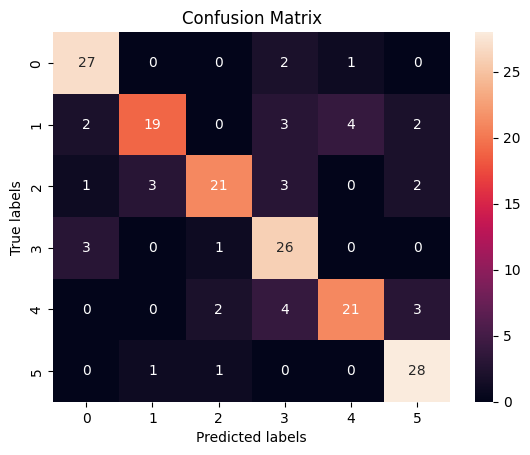

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = classification_report(og_emotion, predicted_emotion)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');